In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/Reemsoliiman/customer-churn-prediction-analysis/main/data/churn-bigml-80.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [5]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [6]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
df.tail(10)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
2656,GA,122,510,Yes,No,0,140.0,101,23.80,196.4,77,16.69,120.1,133,5.40,9.7,4,2.62,4,True
2657,MD,62,408,No,No,0,321.1,105,54.59,265.5,122,22.57,180.5,72,8.12,11.5,2,3.11,4,True
2658,IN,117,415,No,No,0,118.4,126,20.13,249.3,97,21.19,227.0,56,10.22,13.6,3,3.67,5,True
2659,OH,78,408,No,No,0,193.4,99,32.88,116.9,88,9.94,243.3,109,10.95,9.3,4,2.51,2,False
2660,OH,96,415,No,No,0,106.6,128,18.12,284.8,87,24.21,178.9,92,8.05,14.9,7,4.02,1,False
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
2665,TN,74,415,No,Yes,25,234.4,113,39.85,265.9,82,22.60,241.4,77,10.86,13.7,4,3.70,0,False


In [8]:
numeric_cols = [
    "Number vmail messages", "Total day minutes", "Total eve minutes", 
    "Total night minutes", "Total intl minutes", "Total intl calls", 
    "Customer service calls"
]

outliers_df = pd.DataFrame()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers_df[col] = mask

rows_with_outliers = df[outliers_df.any(axis=1)]

print(f"rows with outliers : {len(rows_with_outliers)}")
rows_with_outliers.head()


rows with outliers : 364


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
6,MA,121,510,No,Yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
12,IA,62,415,No,No,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,False
18,CO,77,408,No,No,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,True
19,AZ,130,415,No,No,0,183.0,112,31.11,72.9,99,6.20,181.8,78,8.18,9.5,19,2.57,0,False
27,LA,172,408,No,No,0,212.0,121,36.04,31.2,115,2.65,293.3,78,13.20,12.6,10,3.40,3,False


In [9]:
for col in rows_with_outliers.columns:
    print(f"{col}: {rows_with_outliers[col].nunique()} unique values ")


State: 51 unique values 
Account length: 143 unique values 
Area code: 3 unique values 
International plan: 2 unique values 
Voice mail plan: 2 unique values 
Number vmail messages: 33 unique values 
Total day minutes: 339 unique values 
Total day calls: 89 unique values 
Total day charge: 339 unique values 
Total eve minutes: 338 unique values 
Total eve calls: 88 unique values 
Total eve charge: 329 unique values 
Total night minutes: 327 unique values 
Total night calls: 87 unique values 
Total night charge: 289 unique values 
Total intl minutes: 126 unique values 
Total intl calls: 21 unique values 
Total intl charge: 126 unique values 
Customer service calls: 10 unique values 
Churn: 2 unique values 


In [10]:
numeric_cols = [
    "Number vmail messages", "Total day minutes", "Total day charge",
    "Total eve minutes", "Total eve charge",
    "Total night minutes", "Total night charge",
    "Total intl minutes", "Total intl charge",
    "Total intl calls", "Customer service calls"
]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip values to within bounds
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)



In [11]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.019880,179.533777,100.310203,30.521279,200.424944,100.023631,17.036363,201.121568,100.106152,9.050554,10.254276,4.411478,2.769220,1.477869
std,39.563974,42.521018,13.606662,53.835098,19.988162,9.151706,50.681362,20.161445,4.307806,50.380308,19.418459,2.267025,2.715774,2.262104,0.733013,1.105791
min,1.000000,408.000000,0.000000,34.650000,0.000000,5.900000,60.600000,0.000000,5.155000,62.600000,33.000000,2.821250,3.100000,0.000000,0.845000,0.000000
25%,73.000000,408.000000,0.000000,143.400000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.950000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.900000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,47.500000,324.650000,160.000000,55.180000,339.800000,170.000000,28.875000,340.800000,166.000000,15.331250,17.500000,10.500000,4.725000,3.500000


In [12]:
outliers_count = 0
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count += df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

print(f"rows with outliers : {outliers_count}")




rows with outliers : 0


In [13]:
duplicates = df[df.duplicated()]
print(f" rows with duplicates :{duplicates.shape[0]}")
duplicates.head()

 rows with duplicates :0


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn


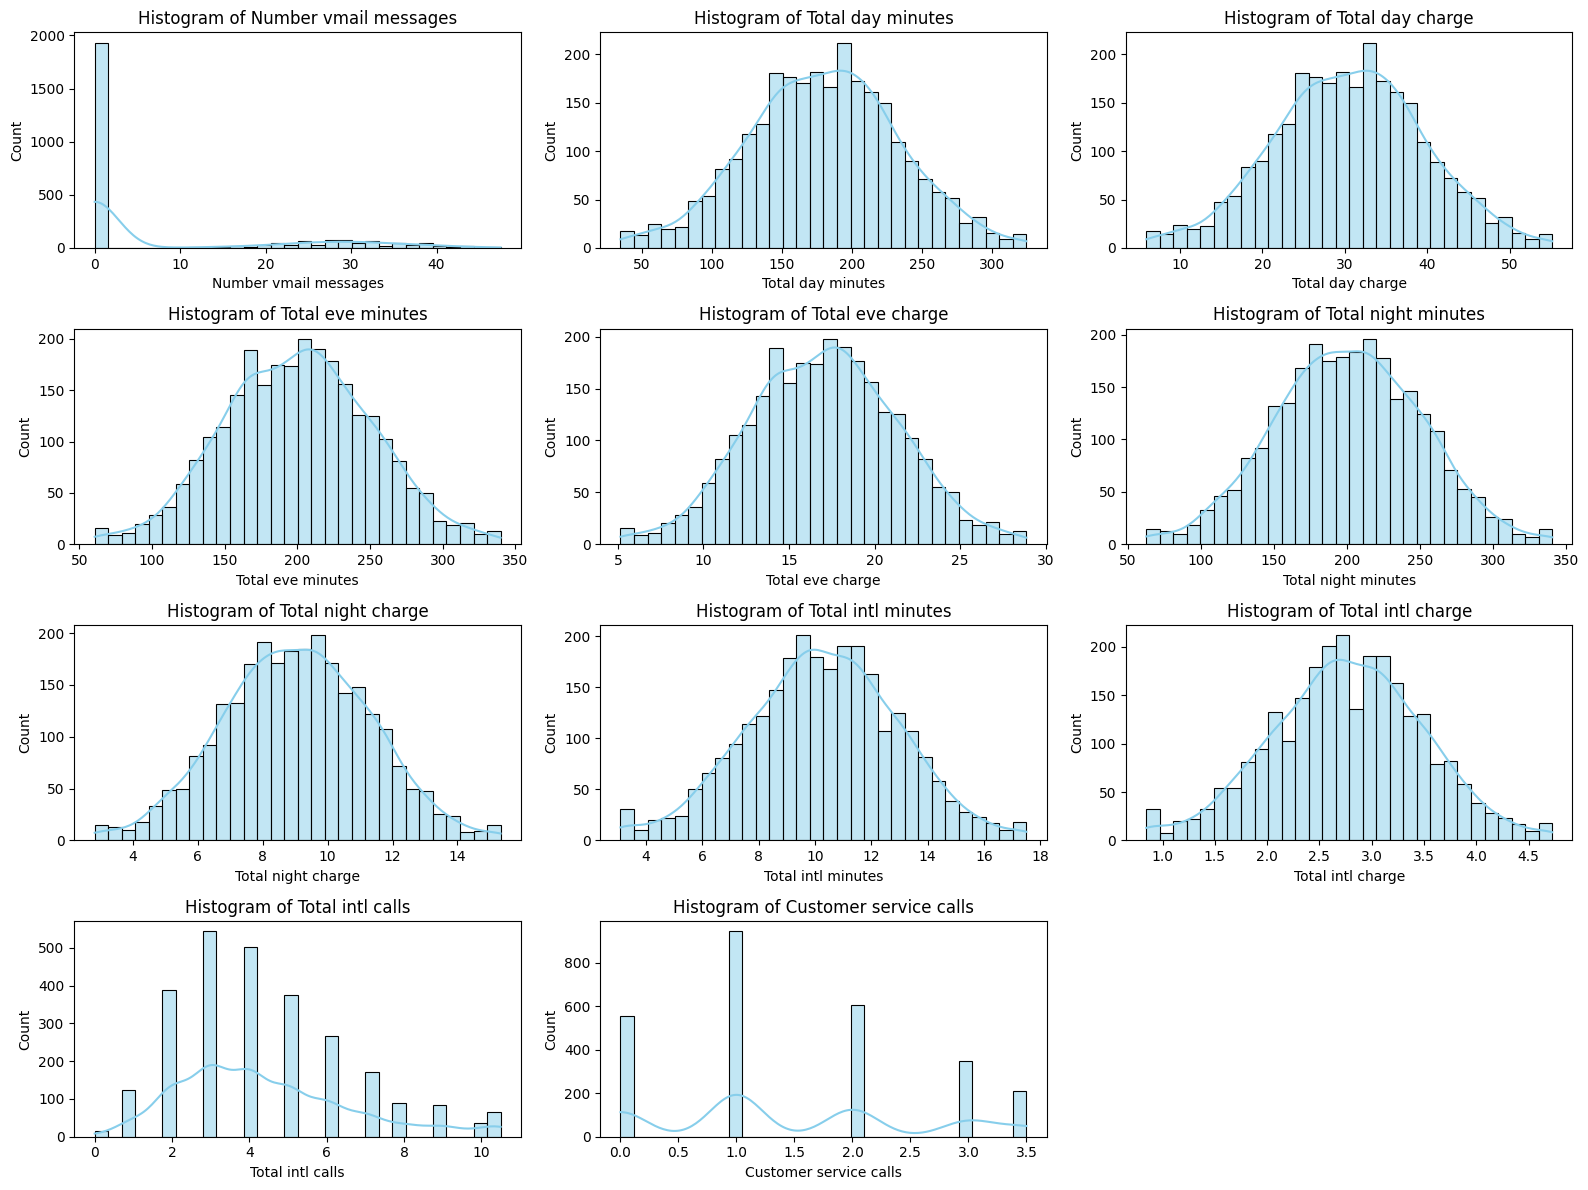

In [14]:
# Histograms for numeric columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

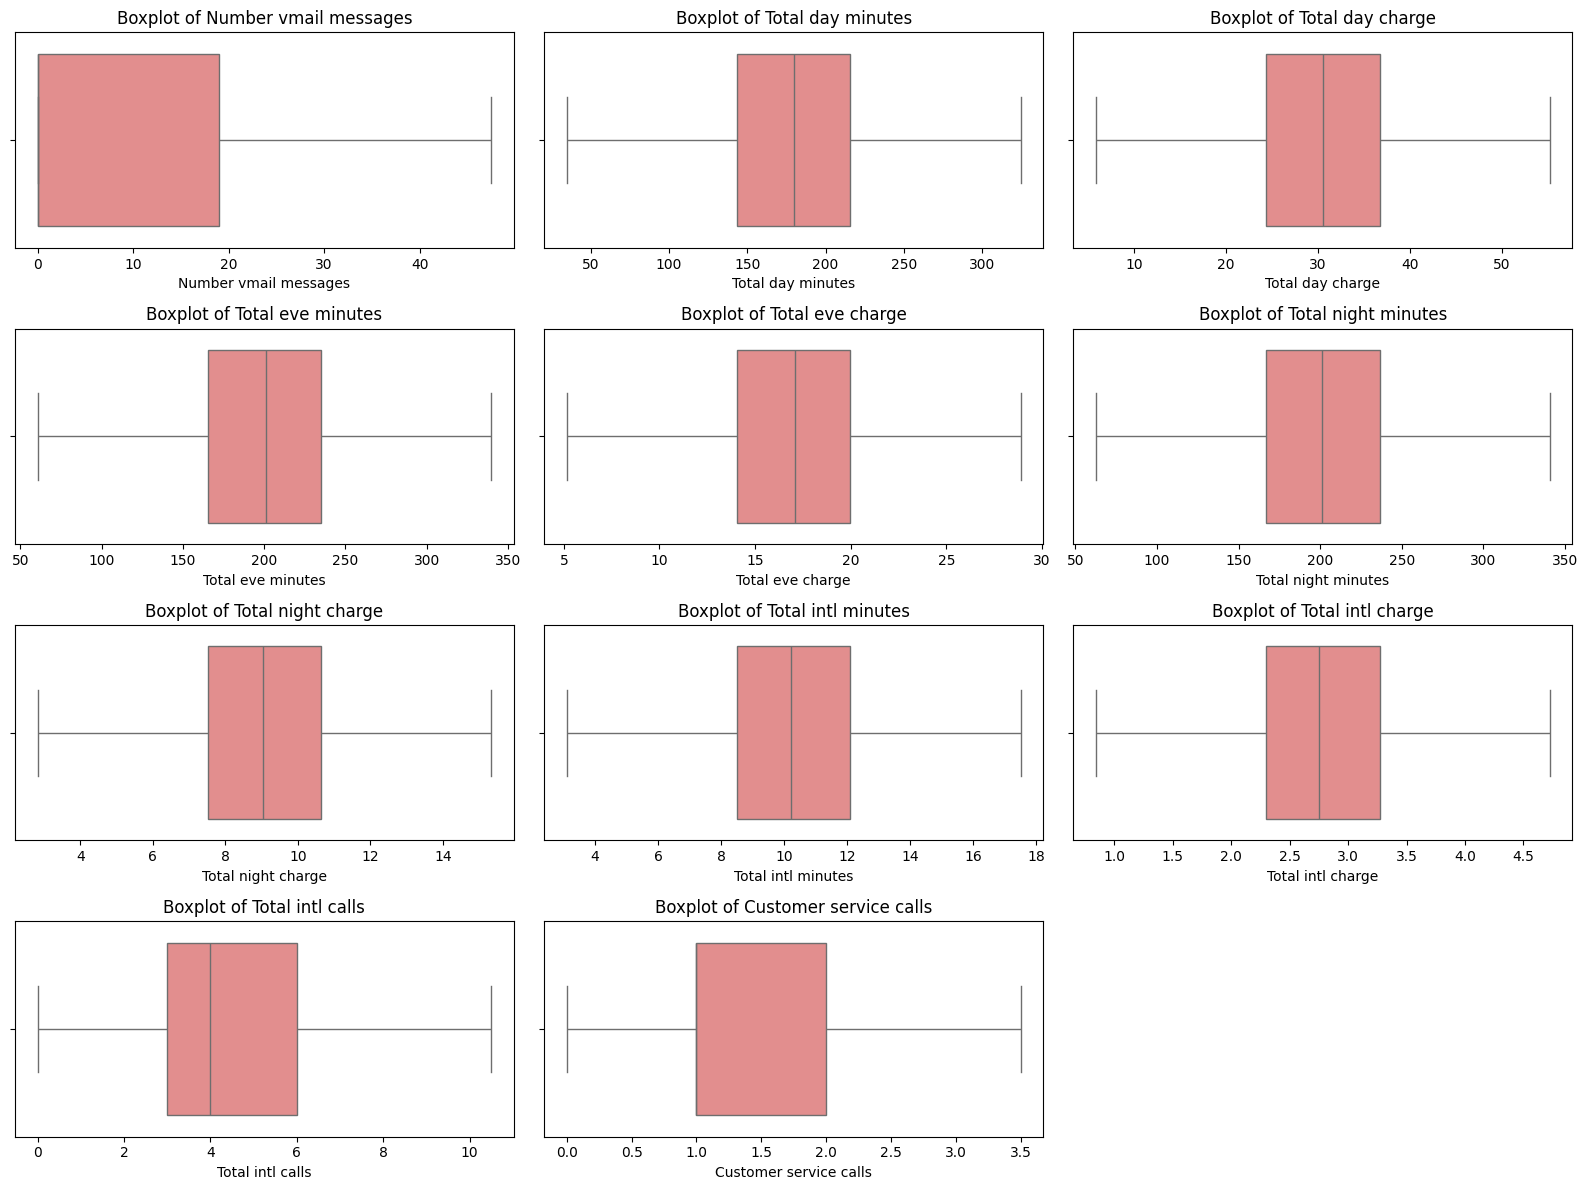

In [15]:
# Boxplots for numeric columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col], color="lightcoral")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

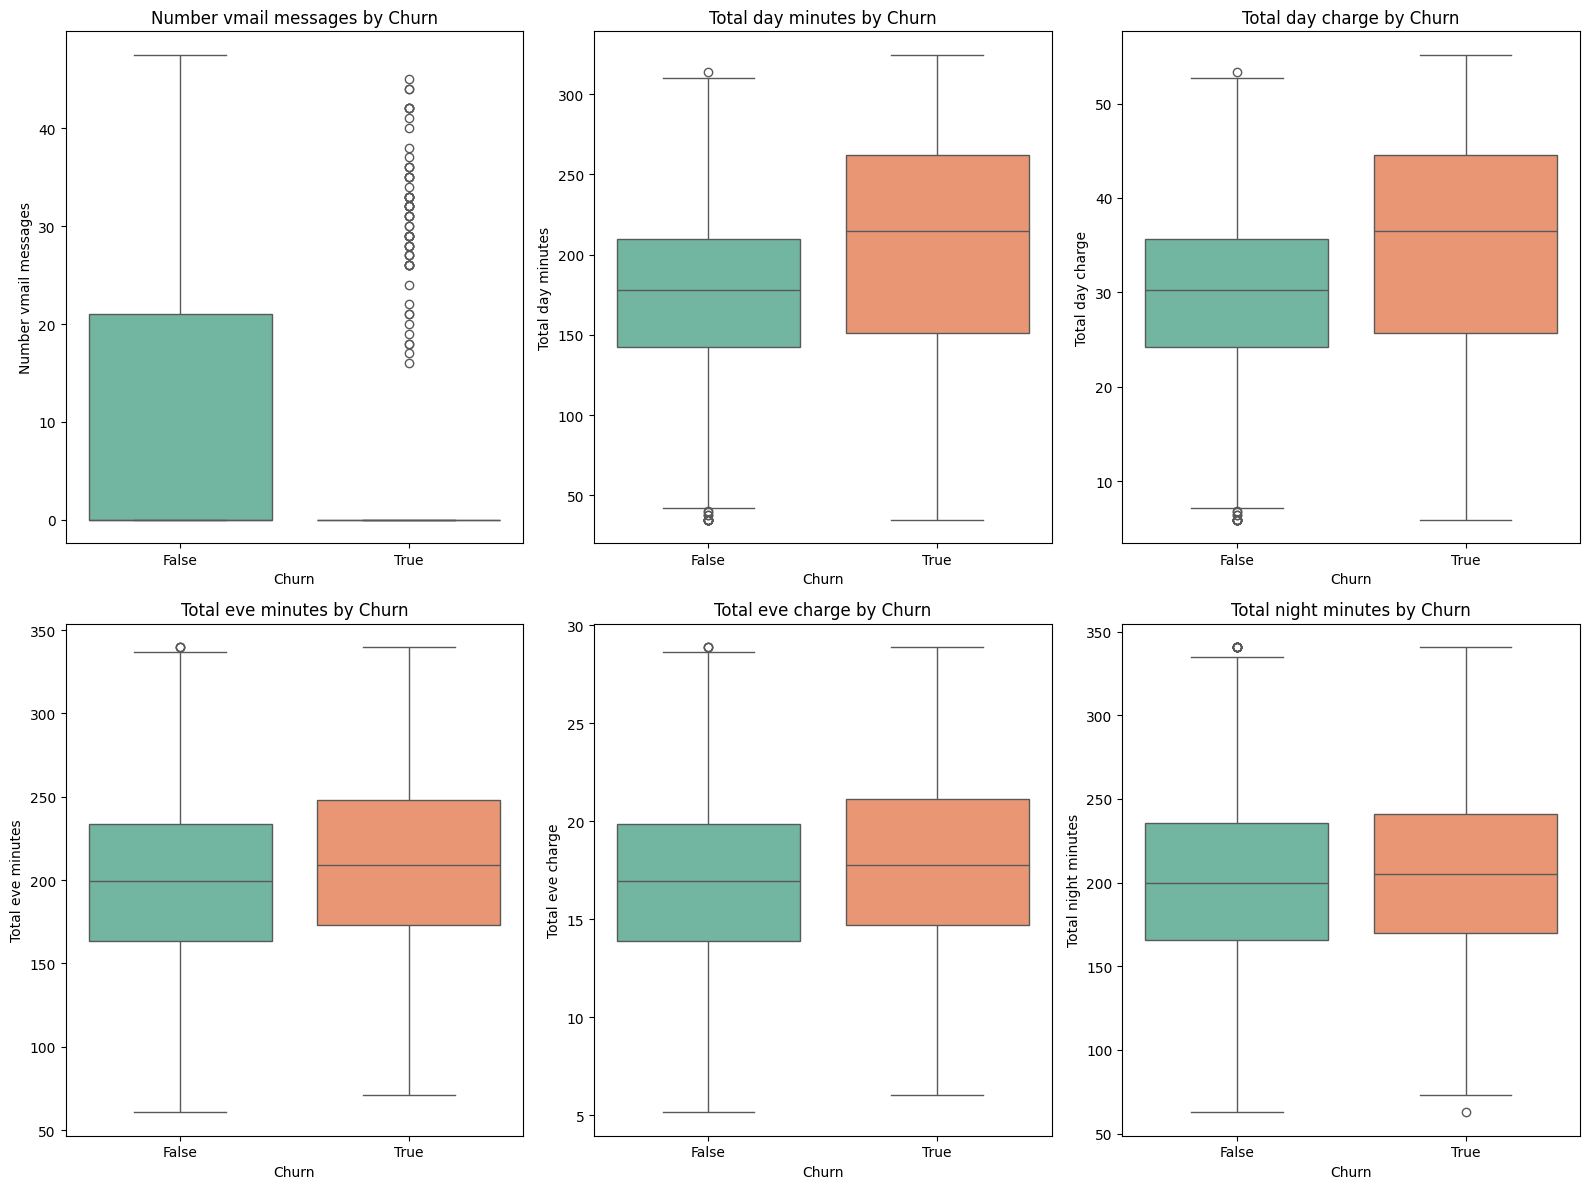

In [22]:
# Boxplots by Churn (compare groups)
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols[:6], 1): 
    plt.subplot(2, 3, i)
    sns.boxplot(x="Churn", y=col, data=df, hue="Churn", palette="Set2", legend=False)
    plt.title(f"{col} by Churn")
plt.tight_layout()
plt.show()

In [19]:
df_before = pd.read_csv(url)  

# Define numeric columns
numeric_cols = [
    "Number vmail messages", "Total day minutes", "Total day charge",
    "Total eve minutes", "Total eve charge",
    "Total night minutes", "Total night charge",
    "Total intl minutes", "Total intl charge",
    "Total intl calls", "Customer service calls"
]


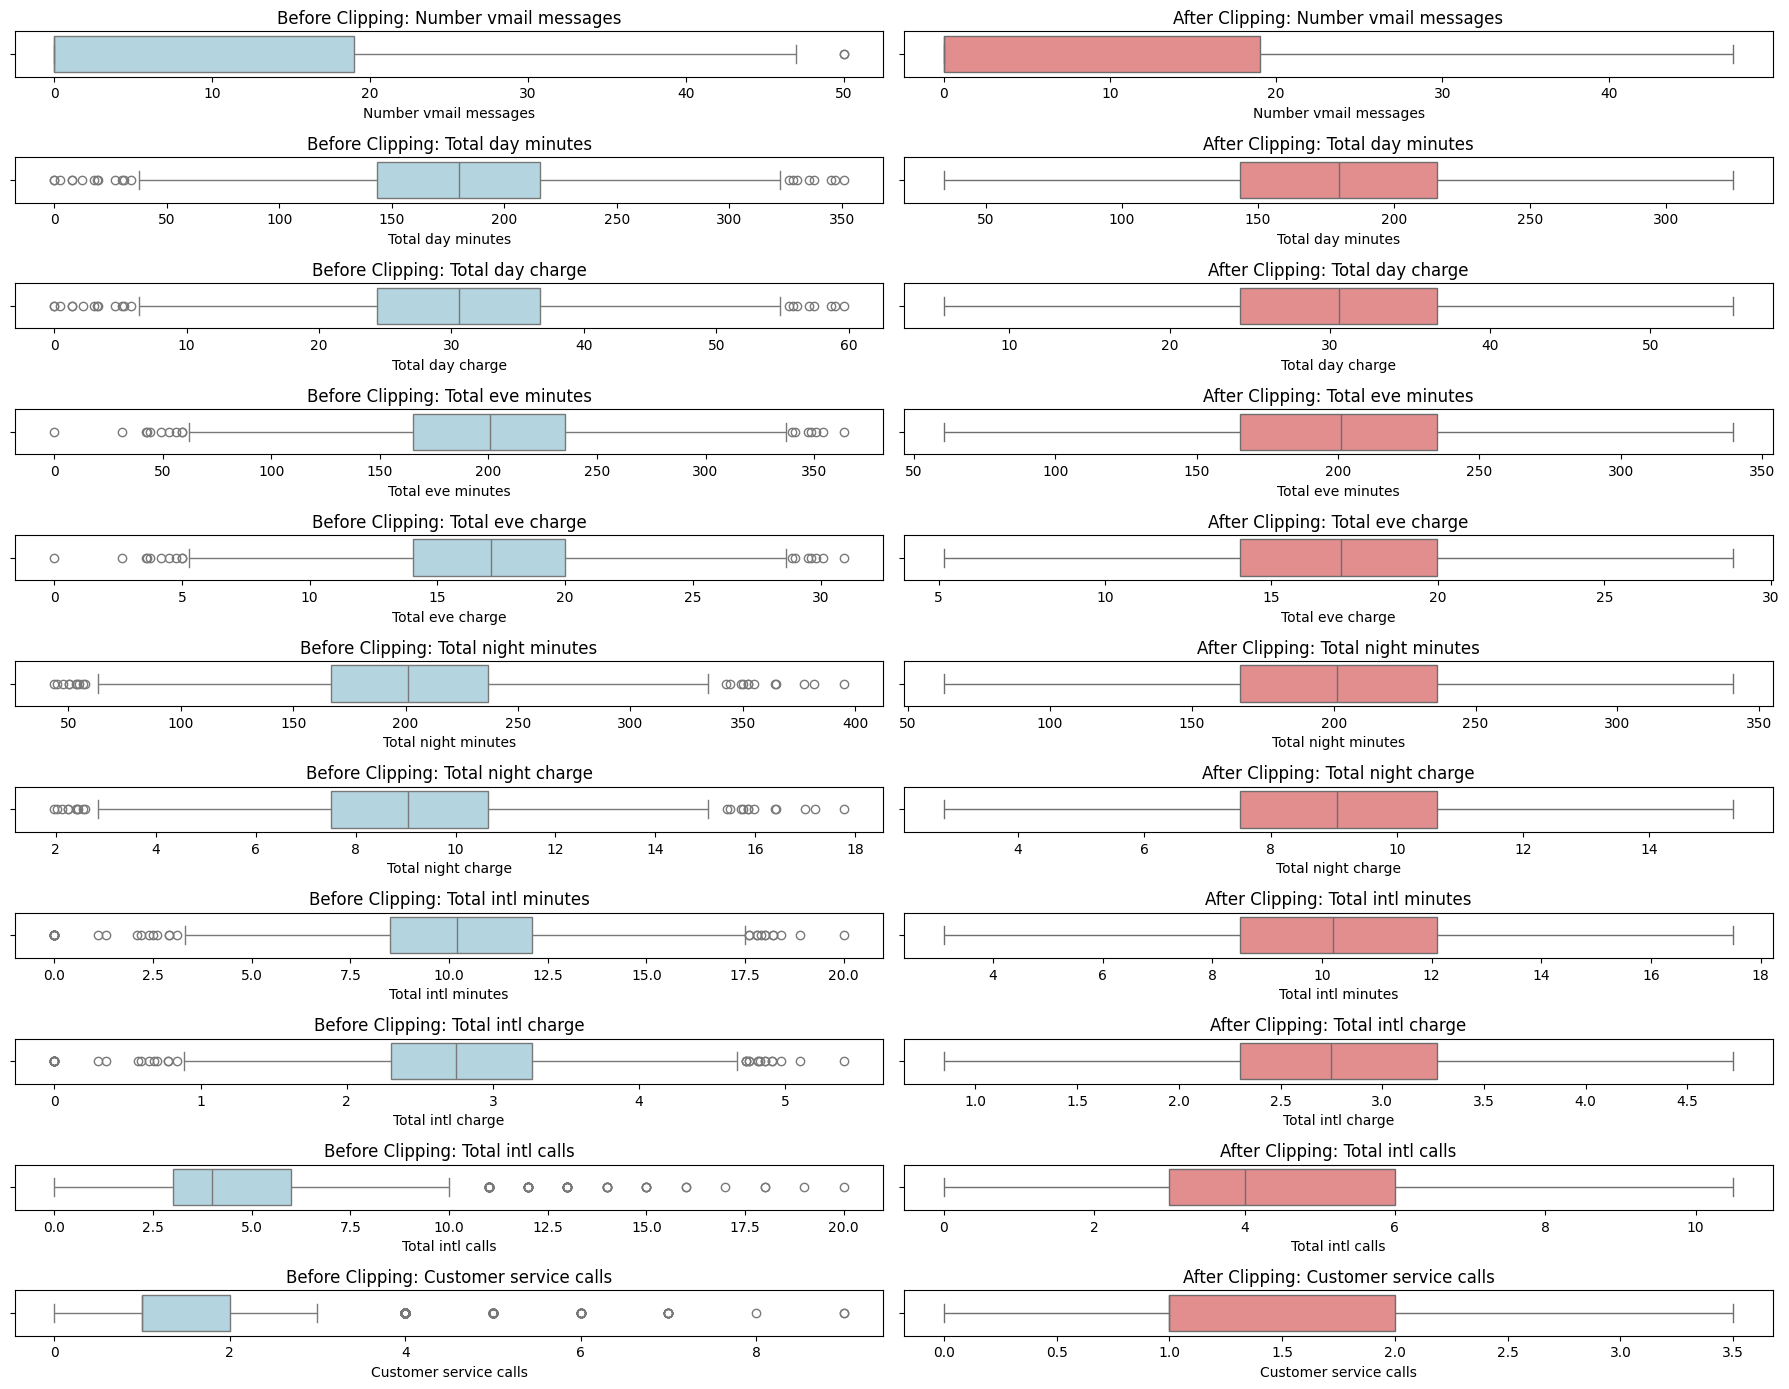

In [20]:
# Side-by-side Boxplots: Before vs After Clipping
plt.figure(figsize=(18, 14))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, 2*i-1)
    sns.boxplot(x=df_before[col], color="lightblue")
    plt.title(f"Before Clipping: {col}")

    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.boxplot(x=df[col], color="lightcoral")
    plt.title(f"After Clipping: {col}")

plt.tight_layout()
plt.show()

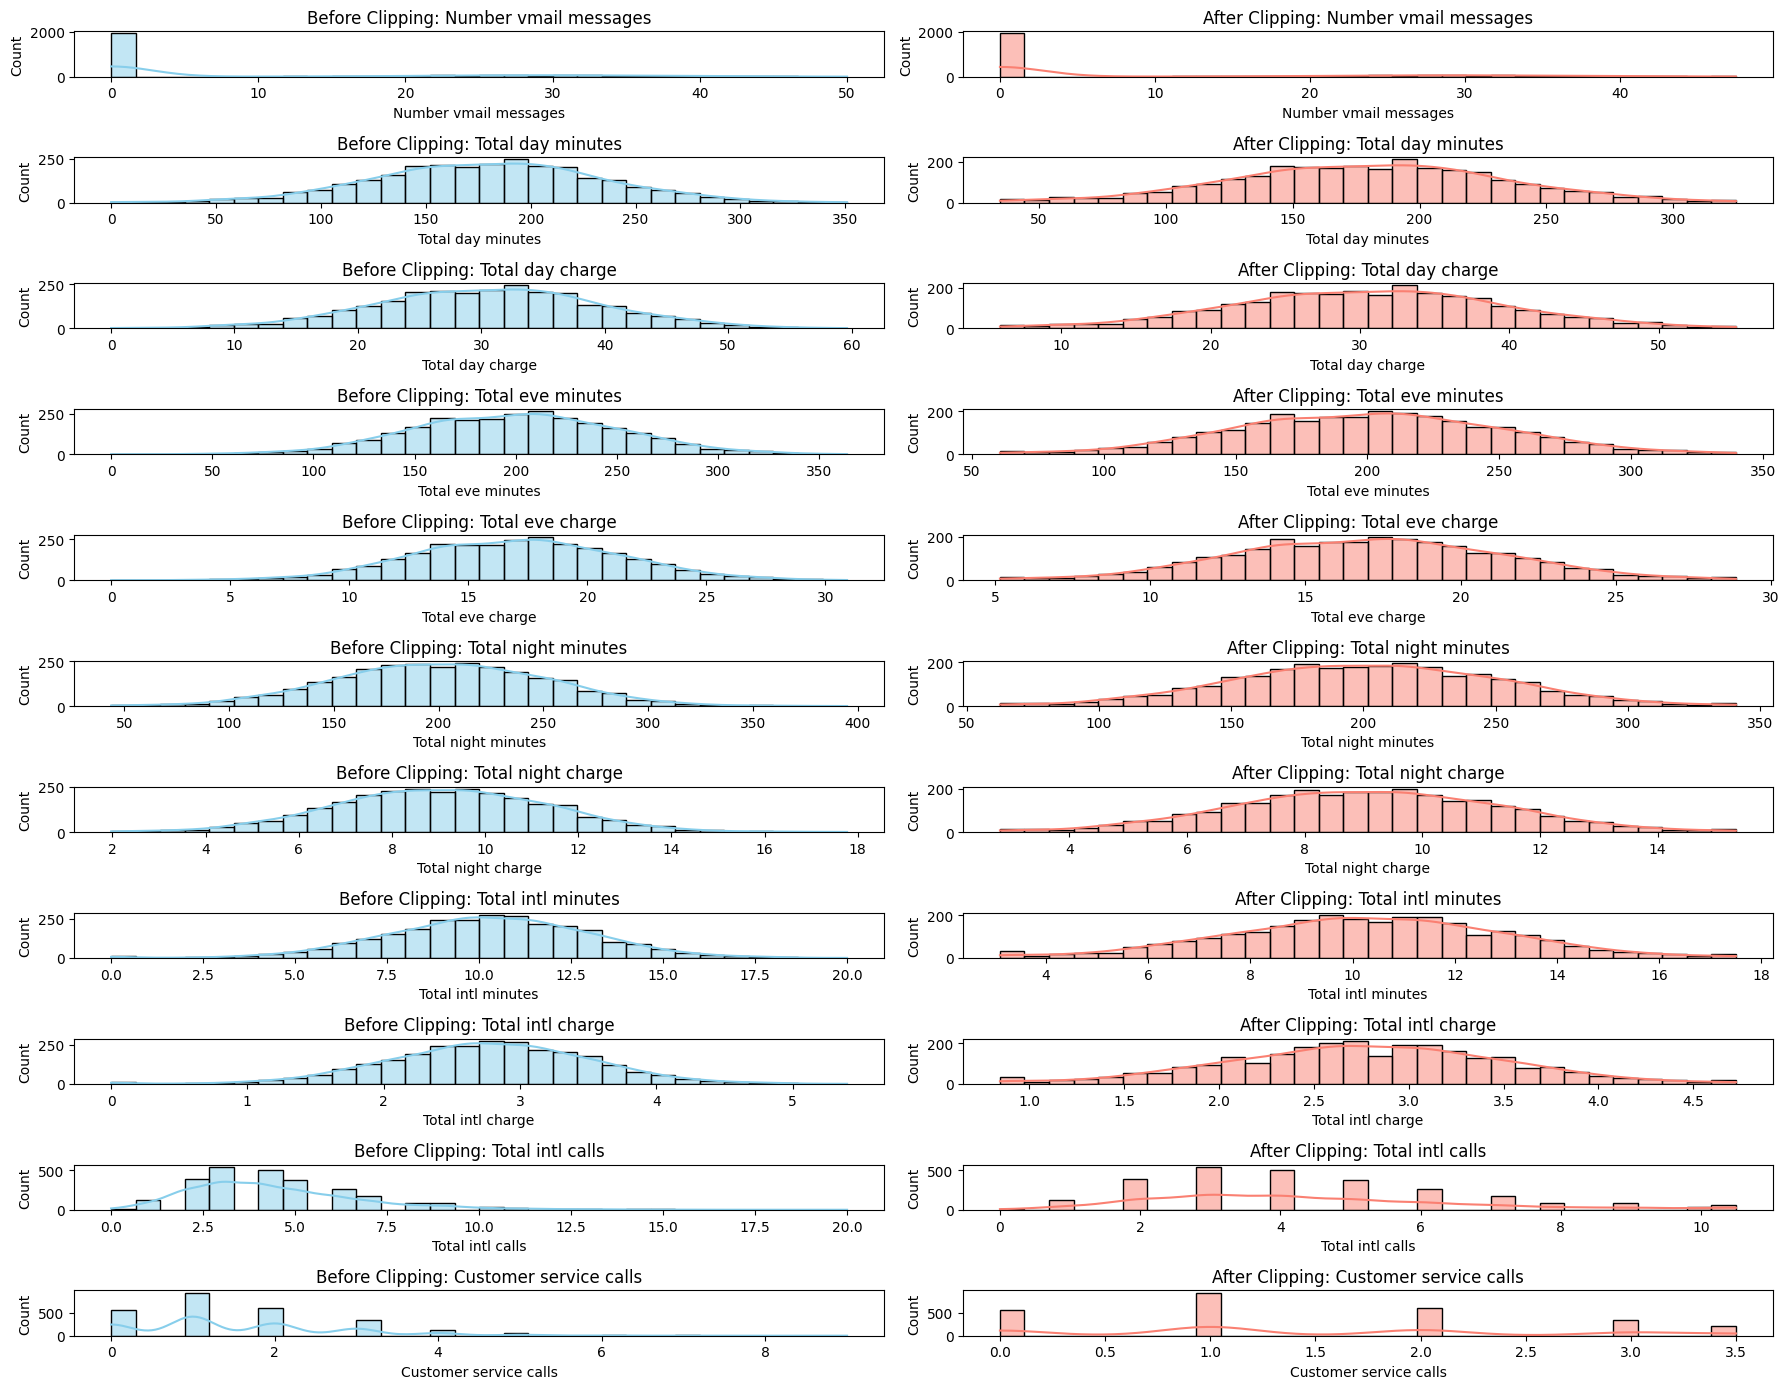

In [21]:
# Side-by-side Histograms: Before vs After Clipping
plt.figure(figsize=(18, 14))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, 2*i-1)
    sns.histplot(df_before[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Before Clipping: {col}")

    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.histplot(df[col], kde=True, bins=30, color="salmon")
    plt.title(f"After Clipping: {col}")

plt.tight_layout()
plt.show()